In [1]:
import cv2
import numpy as np
from PIL import Image
import os
import json
import pandas as pd

In [2]:
import csv

In [3]:
def load_heatmap(heatmap_path):
    heatmap = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)
    return heatmap

In [4]:
def resize_heatmap(heatmap, target_size):
    # Resize heatmap to match the original image resolution
    resized_heatmap = cv2.resize(
        heatmap, target_size, interpolation=cv2.INTER_AREA)
    return resized_heatmap

In [5]:
# Example usage
original_image = Image.open('./good_data/data/images/train_s/p101.jpg')
original_size = original_image.size  # (width, height)

heatmap = load_heatmap('./good_data/data/heatmaps/train_s/p101.png')
resized_heatmap = resize_heatmap(heatmap, original_size)

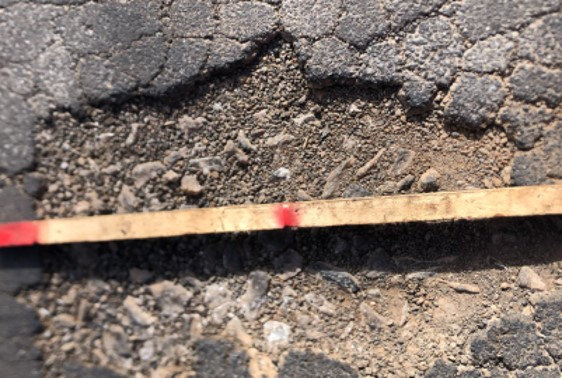

In [6]:
original_image

In [7]:
print(original_size)
print(heatmap.shape)
print(resized_heatmap.shape)

(562, 378)
(2160, 3840)
(378, 562)


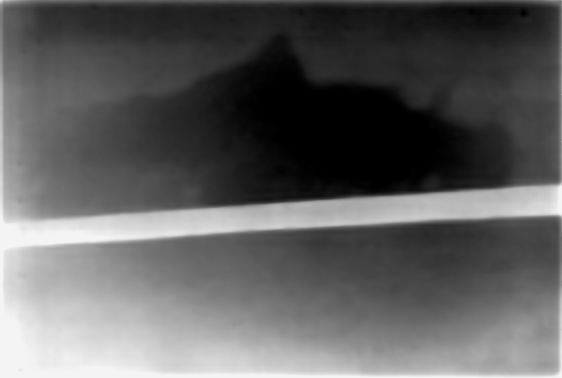

In [8]:
Image.fromarray(resized_heatmap)

In [9]:
def crop_heatmap_with_bbox(resized_heatmap, bbox):
    # bbox is assumed to be in the format (x_center, y_center, width, height) in YOLO format
    img_height, img_width = resized_heatmap.shape
    x_center, y_center, width, height = bbox

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    cropped_heatmap = resized_heatmap[y_min:y_max, x_min:x_max]
    return cropped_heatmap

In [10]:
# Example usage
bbox = (0.5, 0.5, 0.6, 0.4)  # Example values in YOLO format
cropped_heatmap = crop_heatmap_with_bbox(resized_heatmap, bbox)

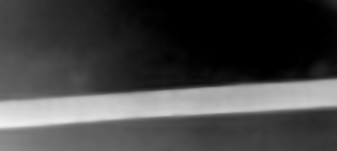

In [11]:
Image.fromarray(cropped_heatmap)

In [12]:
def estimate_depth(cropped_heatmap):
    min_intensity = np.min(cropped_heatmap)
    max_intensity = np.max(cropped_heatmap)
    # Difference in intensity as a proxy for depth
    depth_estimate = max_intensity - min_intensity
    return depth_estimate

In [13]:
# Example usage
depth_estimate = estimate_depth(cropped_heatmap)
print(depth_estimate)

241


In [14]:
def normalize_depth(depth_estimate, min_depth=0, max_depth=100):
    # Normalize depth estimate to a range (e.g., 0 to 100 mm)
    normalized_depth = (depth_estimate / 255.0) * \
        (max_depth - min_depth) + min_depth
    return normalized_depth

In [15]:
# Example usage
normalized_depth = normalize_depth(depth_estimate)
print(normalized_depth)

94.50980392156862


# Put together

In [16]:
# Directory paths
heatmap_dir = './good_data/data/heatmaps/train_s'
image_dir = './good_data/data/images/train_s'
bbox_dir = './good_data/data/labels/train_s'

In [17]:
depth_features = []
intensity_features = []
dud_images = []  # List to keep track of images without pothole annotations

In [18]:
for image_filename in os.listdir(image_dir):
    # Load the original image and corresponding heatmap
    image_path = os.path.join(image_dir, image_filename)
    heatmap_path = os.path.join(
        heatmap_dir, image_filename.replace('.jpg', '.png'))
    bbox_path = os.path.join(bbox_dir, image_filename.replace('.jpg', '.txt'))

    # Load image, heatmap, and bounding box data
    original_image = Image.open(image_path)
    heatmap = load_heatmap(heatmap_path)
    resized_heatmap = resize_heatmap(heatmap, original_image.size)

    # Initialize variables for bounding box search
    pothole_bbox = None

    # Parse bounding box data (assuming YOLO format)
    with open(bbox_path, 'r') as f:
        for line in f.readlines():
            bbox_data = line.strip().split()
            if bbox_data[0] == '0':  # '0' indicates the pothole
                # Assuming bbox is the second to fifth values
                pothole_bbox = tuple(map(float, bbox_data[1:]))
                break  # Stop searching once we find the pothole annotation

    # Handle cases where no pothole was found in the annotations
    if pothole_bbox is None:
        print(f"No pothole found in {image_filename}, marking as dud.")
        dud_images.append(image_filename)
        continue  # Skip to the next image

    # Crop the heatmap and estimate depth
    cropped_heatmap = crop_heatmap_with_bbox(resized_heatmap, pothole_bbox)
    depth_estimate = estimate_depth(cropped_heatmap)
    normalized_depth = normalize_depth(depth_estimate)

    # Calculate intensity features
    avg_intensity = np.mean(cropped_heatmap)
    intensity_range = np.max(cropped_heatmap) - np.min(cropped_heatmap)
    intensity_std = np.std(cropped_heatmap)

    # Append the features to the respective lists
    depth_features.append((image_filename, normalized_depth))
    intensity_features.append(
        (image_filename, avg_intensity, intensity_range, intensity_std))

No pothole found in p1047.jpg, marking as dud.
No pothole found in p1051.jpg, marking as dud.
No pothole found in p1052.jpg, marking as dud.
No pothole found in p1054.jpg, marking as dud.
No pothole found in p1058.jpg, marking as dud.
No pothole found in p1081.jpg, marking as dud.
No pothole found in p1091.jpg, marking as dud.
No pothole found in p110.jpg, marking as dud.
No pothole found in p1102.jpg, marking as dud.
No pothole found in p1106.jpg, marking as dud.
No pothole found in p111.jpg, marking as dud.
No pothole found in p1116.jpg, marking as dud.
No pothole found in p1121.jpg, marking as dud.
No pothole found in p1122.jpg, marking as dud.
No pothole found in p1125.jpg, marking as dud.
No pothole found in p1126.jpg, marking as dud.
No pothole found in p1127.jpg, marking as dud.
No pothole found in p1128.jpg, marking as dud.
No pothole found in p1133.jpg, marking as dud.
No pothole found in p1135.jpg, marking as dud.
No pothole found in p1139.jpg, marking as dud.
No pothole foun

In [19]:
# Print the dud images for reference
print(f"Total dud images: {len(dud_images)}")
for dud in dud_images:
    print(dud)

Total dud images: 82
p1047.jpg
p1051.jpg
p1052.jpg
p1054.jpg
p1058.jpg
p1081.jpg
p1091.jpg
p110.jpg
p1102.jpg
p1106.jpg
p111.jpg
p1116.jpg
p1121.jpg
p1122.jpg
p1125.jpg
p1126.jpg
p1127.jpg
p1128.jpg
p1133.jpg
p1135.jpg
p1139.jpg
p1141.jpg
p1142.jpg
p1144.jpg
p1155.jpg
p117.jpg
p1185.jpg
p119.jpg
p1196.jpg
p1199.jpg
p1200.jpg
p1217.jpg
p122.jpg
p1229.jpg
p123.jpg
p1230.jpg
p1231.jpg
p1236.jpg
p1243.jpg
p1245.jpg
p1254.jpg
p1257.jpg
p1258.jpg
p1264.jpg
p1265.jpg
p1268.jpg
p1272.jpg
p1274.jpg
p1281.jpg
p1287.jpg
p1305.jpg
p1309.jpg
p1312.jpg
p1313.jpg
p1318.jpg
p1326.jpg
p1331.jpg
p1332.jpg
p1333.jpg
p1336.jpg
p1337.jpg
p1342.jpg
p1344.jpg
p1347.jpg
p1349.jpg
p135.jpg
p1354.jpg
p136.jpg
p1406.jpg
p1417.jpg
p1418.jpg
p1420.jpg
p1424.jpg
p1427.jpg
p1442.jpg
p1443.jpg
p405.jpg
p411.jpg
p412.jpg
p423.jpg
p427.jpg
p438.jpg


In [20]:
depth_features

[('p101.jpg', 95.68627450980392),
 ('p102.jpg', 95.68627450980392),
 ('p1032.jpg', 84.70588235294117),
 ('p1033.jpg', 85.09803921568627),
 ('p1034.jpg', 34.90196078431372),
 ('p1035.jpg', 79.2156862745098),
 ('p1036.jpg', 63.52941176470588),
 ('p1037.jpg', 95.29411764705881),
 ('p1038.jpg', 87.05882352941177),
 ('p1039.jpg', 85.88235294117646),
 ('p1041.jpg', 39.6078431372549),
 ('p1042.jpg', 62.745098039215684),
 ('p1043.jpg', 37.254901960784316),
 ('p1048.jpg', 77.25490196078432),
 ('p1049.jpg', 88.23529411764706),
 ('p1055.jpg', 80.0),
 ('p1056.jpg', 56.86274509803921),
 ('p1059.jpg', 79.6078431372549),
 ('p106.jpg', 95.68627450980392),
 ('p1060.jpg', 89.80392156862746),
 ('p1061.jpg', 88.23529411764706),
 ('p1062.jpg', 79.2156862745098),
 ('p1063.jpg', 60.0),
 ('p1064.jpg', 59.21568627450981),
 ('p1065.jpg', 89.01960784313725),
 ('p1069.jpg', 60.0),
 ('p107.jpg', 95.68627450980392),
 ('p1070.jpg', 61.1764705882353),
 ('p1071.jpg', 89.01960784313725),
 ('p1072.jpg', 62.3529411764705

In [21]:
# Load the measurement features from JSON
with open('./good_data/data/measurements/train_s/measurement_features.json', 'r') as f:
    measurement_features = json.load(f)

In [22]:
# Initialize a dictionary to store the combined data
combined_data = {}

# Convert depth features and intensity features to dictionaries for easy lookup
depth_dict = {img: depth for img, depth in depth_features}
intensity_dict = {img: (avg_intensity, intensity_range, intensity_std)
                  for img, avg_intensity, intensity_range, intensity_std in intensity_features}

In [23]:
# Process each image in the measurement features JSON
for img, features in measurement_features.items():
    # If the image is a dud, assign a depth of 0 and intensity features as 0
    depth = depth_dict.get(img, 0)
    avg_intensity, intensity_range, intensity_std = intensity_dict.get(
        img, (0, 0, 0))

    # Combine measurement features with the depth and intensity features
    combined_data[img] = {
        **features,  # Unpack existing measurement features
        "depth_mm": depth,  # Add the depth feature
        "avg_intensity": avg_intensity,  # Add intensity features
        "intensity_range": intensity_range,
        "intensity_std": intensity_std
    }

In [24]:
# Convert the combined data to a pandas DataFrame
df = pd.DataFrame.from_dict(combined_data, orient='index')

# Reset the index to have a clean DataFrame
df.reset_index(inplace=True)
df.rename(columns={'index': 'image_filename'}, inplace=True)

In [25]:
# Display the first few rows of the DataFrame
df.head()

,image_filename,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std
0,p101.jpg,0.000000,0.000000,0.000000,0.000000,95.686275,95.564656,244,68.033727
1,p102.jpg,0.000000,0.000000,0.000000,0.000000,95.686275,85.048637,244,59.694888
2,p1032.jpg,347.156562,459.715656,159593.306601,0.755155,84.705882,64.154414,216,46.081029
3,p1033.jpg,258.911530,344.277797,89137.490912,0.752042,85.098039,98.383151,217,51.441460
4,p1034.jpg,224.615713,324.615534,72913.749549,0.691944,34.901961,128.069083,89,20.138775


# More features

In [26]:
def calculate_severity_index(area_mm2, intensity_range, depth):
    severity_index = area_mm2 * intensity_range * depth  # Just an example formula
    return severity_index

In [27]:
def calculate_area_depth_ratio(area_mm2, depth):
    if area_mm2 != 0:
        area_depth_ratio = depth / area_mm2
    else:
        area_depth_ratio = 0
    return area_depth_ratio

In [28]:
def calculate_interaction_terms(depth, area_mm2, width_mm, height_mm):
    depth_area_interaction = depth * area_mm2
    depth_width_interaction = depth * width_mm
    depth_height_interaction = depth * height_mm
    return depth_area_interaction, depth_width_interaction, depth_height_interaction

In [29]:
# Adding new features to the DataFrame
df['severity_index'] = df.apply(lambda row: calculate_severity_index(
    row['area_mm2'], row['intensity_range'], row['depth_mm']), axis=1)
df['depth_area_interaction'], df['depth_width_interaction'], df['depth_height_interaction'] = zip(
    *df.apply(lambda row: calculate_interaction_terms(row['depth_mm'], row['area_mm2'], row['width_mm'], row['height_mm']), axis=1))

In [30]:
df.head()

,image_filename,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction
0,p101.jpg,0.000000,0.000000,0.000000,0.000000,95.686275,95.564656,244,68.033727,0.000000e+00,0.000000e+00,0.000000,0.000000
1,p102.jpg,0.000000,0.000000,0.000000,0.000000,95.686275,85.048637,244,59.694888,0.000000e+00,0.000000e+00,0.000000,0.000000
2,p1032.jpg,347.156562,459.715656,159593.306601,0.755155,84.705882,64.154414,216,46.081029,2.919994e+09,1.351849e+07,29406.202881,38940.620288
3,p1033.jpg,258.911530,344.277797,89137.490912,0.752042,85.098039,98.383151,217,51.441460,1.646037e+09,7.585426e+06,22032.863491,29297.365443
4,p1034.jpg,224.615713,324.615534,72913.749549,0.691944,34.901961,128.069083,89,20.138775,2.264901e+08,2.544833e+06,7839.528808,11329.718625


In [31]:
bags_df = pd.read_csv('./data_full/filtered_train_labels.csv')

In [32]:
bags_df.head()

,Pothole number,Bags used
0,101,0.5
1,102,1.0
2,106,0.5
3,107,0.5
4,109,0.5


In [33]:
df['image_filename'] = df['image_filename'].apply(lambda x: x.split('.')[0][1:])
df.rename(columns={'image_filename': 'Pothole number'}, inplace=True)
df.head()

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction
0,101,0.000000,0.000000,0.000000,0.000000,95.686275,95.564656,244,68.033727,0.000000e+00,0.000000e+00,0.000000,0.000000
1,102,0.000000,0.000000,0.000000,0.000000,95.686275,85.048637,244,59.694888,0.000000e+00,0.000000e+00,0.000000,0.000000
2,1032,347.156562,459.715656,159593.306601,0.755155,84.705882,64.154414,216,46.081029,2.919994e+09,1.351849e+07,29406.202881,38940.620288
3,1033,258.911530,344.277797,89137.490912,0.752042,85.098039,98.383151,217,51.441460,1.646037e+09,7.585426e+06,22032.863491,29297.365443
4,1034,224.615713,324.615534,72913.749549,0.691944,34.901961,128.069083,89,20.138775,2.264901e+08,2.544833e+06,7839.528808,11329.718625


In [34]:
df['Pothole number'] = df['Pothole number'].astype(int)

In [35]:
df.sort_values(by='Pothole number', inplace=True)
df.reset_index(drop=True, inplace=True)

In [36]:
df

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction
0,101,0.000000,0.000000,0.000000e+00,0.000000,95.686275,95.564656,244,68.033727,0.000000e+00,0.000000e+00,0.000000,0.000000
1,102,0.000000,0.000000,0.000000e+00,0.000000,95.686275,85.048637,244,59.694888,0.000000e+00,0.000000e+00,0.000000,0.000000
2,106,766.318783,570.496439,4.371821e+05,1.343249,95.686275,54.316676,244,55.893129,1.020709e+10,4.183233e+07,73326.189406,54588.678900
3,107,529.210437,628.866134,3.328025e+05,0.841531,95.686275,63.230865,244,59.609284,7.770091e+09,3.184463e+07,50638.175175,60173.857555
4,109,1006.850645,1166.667554,1.174660e+06,0.863014,75.294118,89.596951,192,47.322335,1.698144e+10,8.844499e+07,75809.930915,87843.204068
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,1440,6969.657621,4227.254258,2.946251e+07,1.648743,47.058824,186.001187,120,30.982140,1.663766e+11,1.386471e+09,327983.888064,198929.612125
382,1442,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
383,1443,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
384,1445,1392.855656,2214.283483,3.084177e+06,0.629032,94.117647,46.790969,240,59.741292,6.966612e+10,2.902755e+08,131092.296999,208403.151381


In [37]:
df_full = pd.concat([df, bags_df['Bags used ']], axis=1)

In [38]:
df_full

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction,Bags used
0,101,0.000000,0.000000,0.000000e+00,0.000000,95.686275,95.564656,244,68.033727,0.000000e+00,0.000000e+00,0.000000,0.000000,0.50
1,102,0.000000,0.000000,0.000000e+00,0.000000,95.686275,85.048637,244,59.694888,0.000000e+00,0.000000e+00,0.000000,0.000000,1.00
2,106,766.318783,570.496439,4.371821e+05,1.343249,95.686275,54.316676,244,55.893129,1.020709e+10,4.183233e+07,73326.189406,54588.678900,0.50
3,107,529.210437,628.866134,3.328025e+05,0.841531,95.686275,63.230865,244,59.609284,7.770091e+09,3.184463e+07,50638.175175,60173.857555,0.50
4,109,1006.850645,1166.667554,1.174660e+06,0.863014,75.294118,89.596951,192,47.322335,1.698144e+10,8.844499e+07,75809.930915,87843.204068,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,1440,6969.657621,4227.254258,2.946251e+07,1.648743,47.058824,186.001187,120,30.982140,1.663766e+11,1.386471e+09,327983.888064,198929.612125,1.00
382,1442,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.00
383,1443,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.25
384,1445,1392.855656,2214.283483,3.084177e+06,0.629032,94.117647,46.790969,240,59.741292,6.966612e+10,2.902755e+08,131092.296999,208403.151381,0.50


In [39]:
df_full.describe()

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction,Bags used
count,386.000000,386.000000,386.000000,3.860000e+02,386.000000,386.000000,386.000000,386.000000,386.000000,3.860000e+02,3.860000e+02,3.860000e+02,3.860000e+02,386.000000
mean,961.639896,1406.992483,1124.350555,6.934651e+06,0.654873,54.443767,73.463324,138.831606,32.879478,1.227766e+11,5.658438e+08,1.041086e+05,8.314479e+04,0.792358
std,417.972717,2827.354923,2004.026805,2.895991e+07,0.639497,33.313561,49.373970,84.949581,20.441146,6.312659e+11,2.660827e+09,2.403760e+05,1.726445e+05,1.121924
min,101.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.250000
25%,468.250000,0.000000,0.000000,0.000000e+00,0.000000,35.294118,38.491065,90.000000,21.687574,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.250000
50%,1132.000000,315.667757,397.711988,1.134430e+05,0.718859,61.372549,75.012431,156.500000,36.222114,9.827648e+08,7.232825e+06,1.863877e+04,2.226424e+04,0.500000
75%,1259.750000,1225.920321,1135.293260,1.373250e+06,1.068475,82.745098,113.039518,211.000000,48.733367,1.626467e+10,1.032501e+08,7.848291e+04,7.493934e+04,1.000000
max,1449.000000,25590.815137,16909.025864,4.327158e+08,2.839415,95.686275,186.001187,244.000000,69.591554,9.855907e+12,4.089588e+10,2.418583e+06,1.598069e+06,12.000000


In [40]:
from matplotlib import pyplot as plt

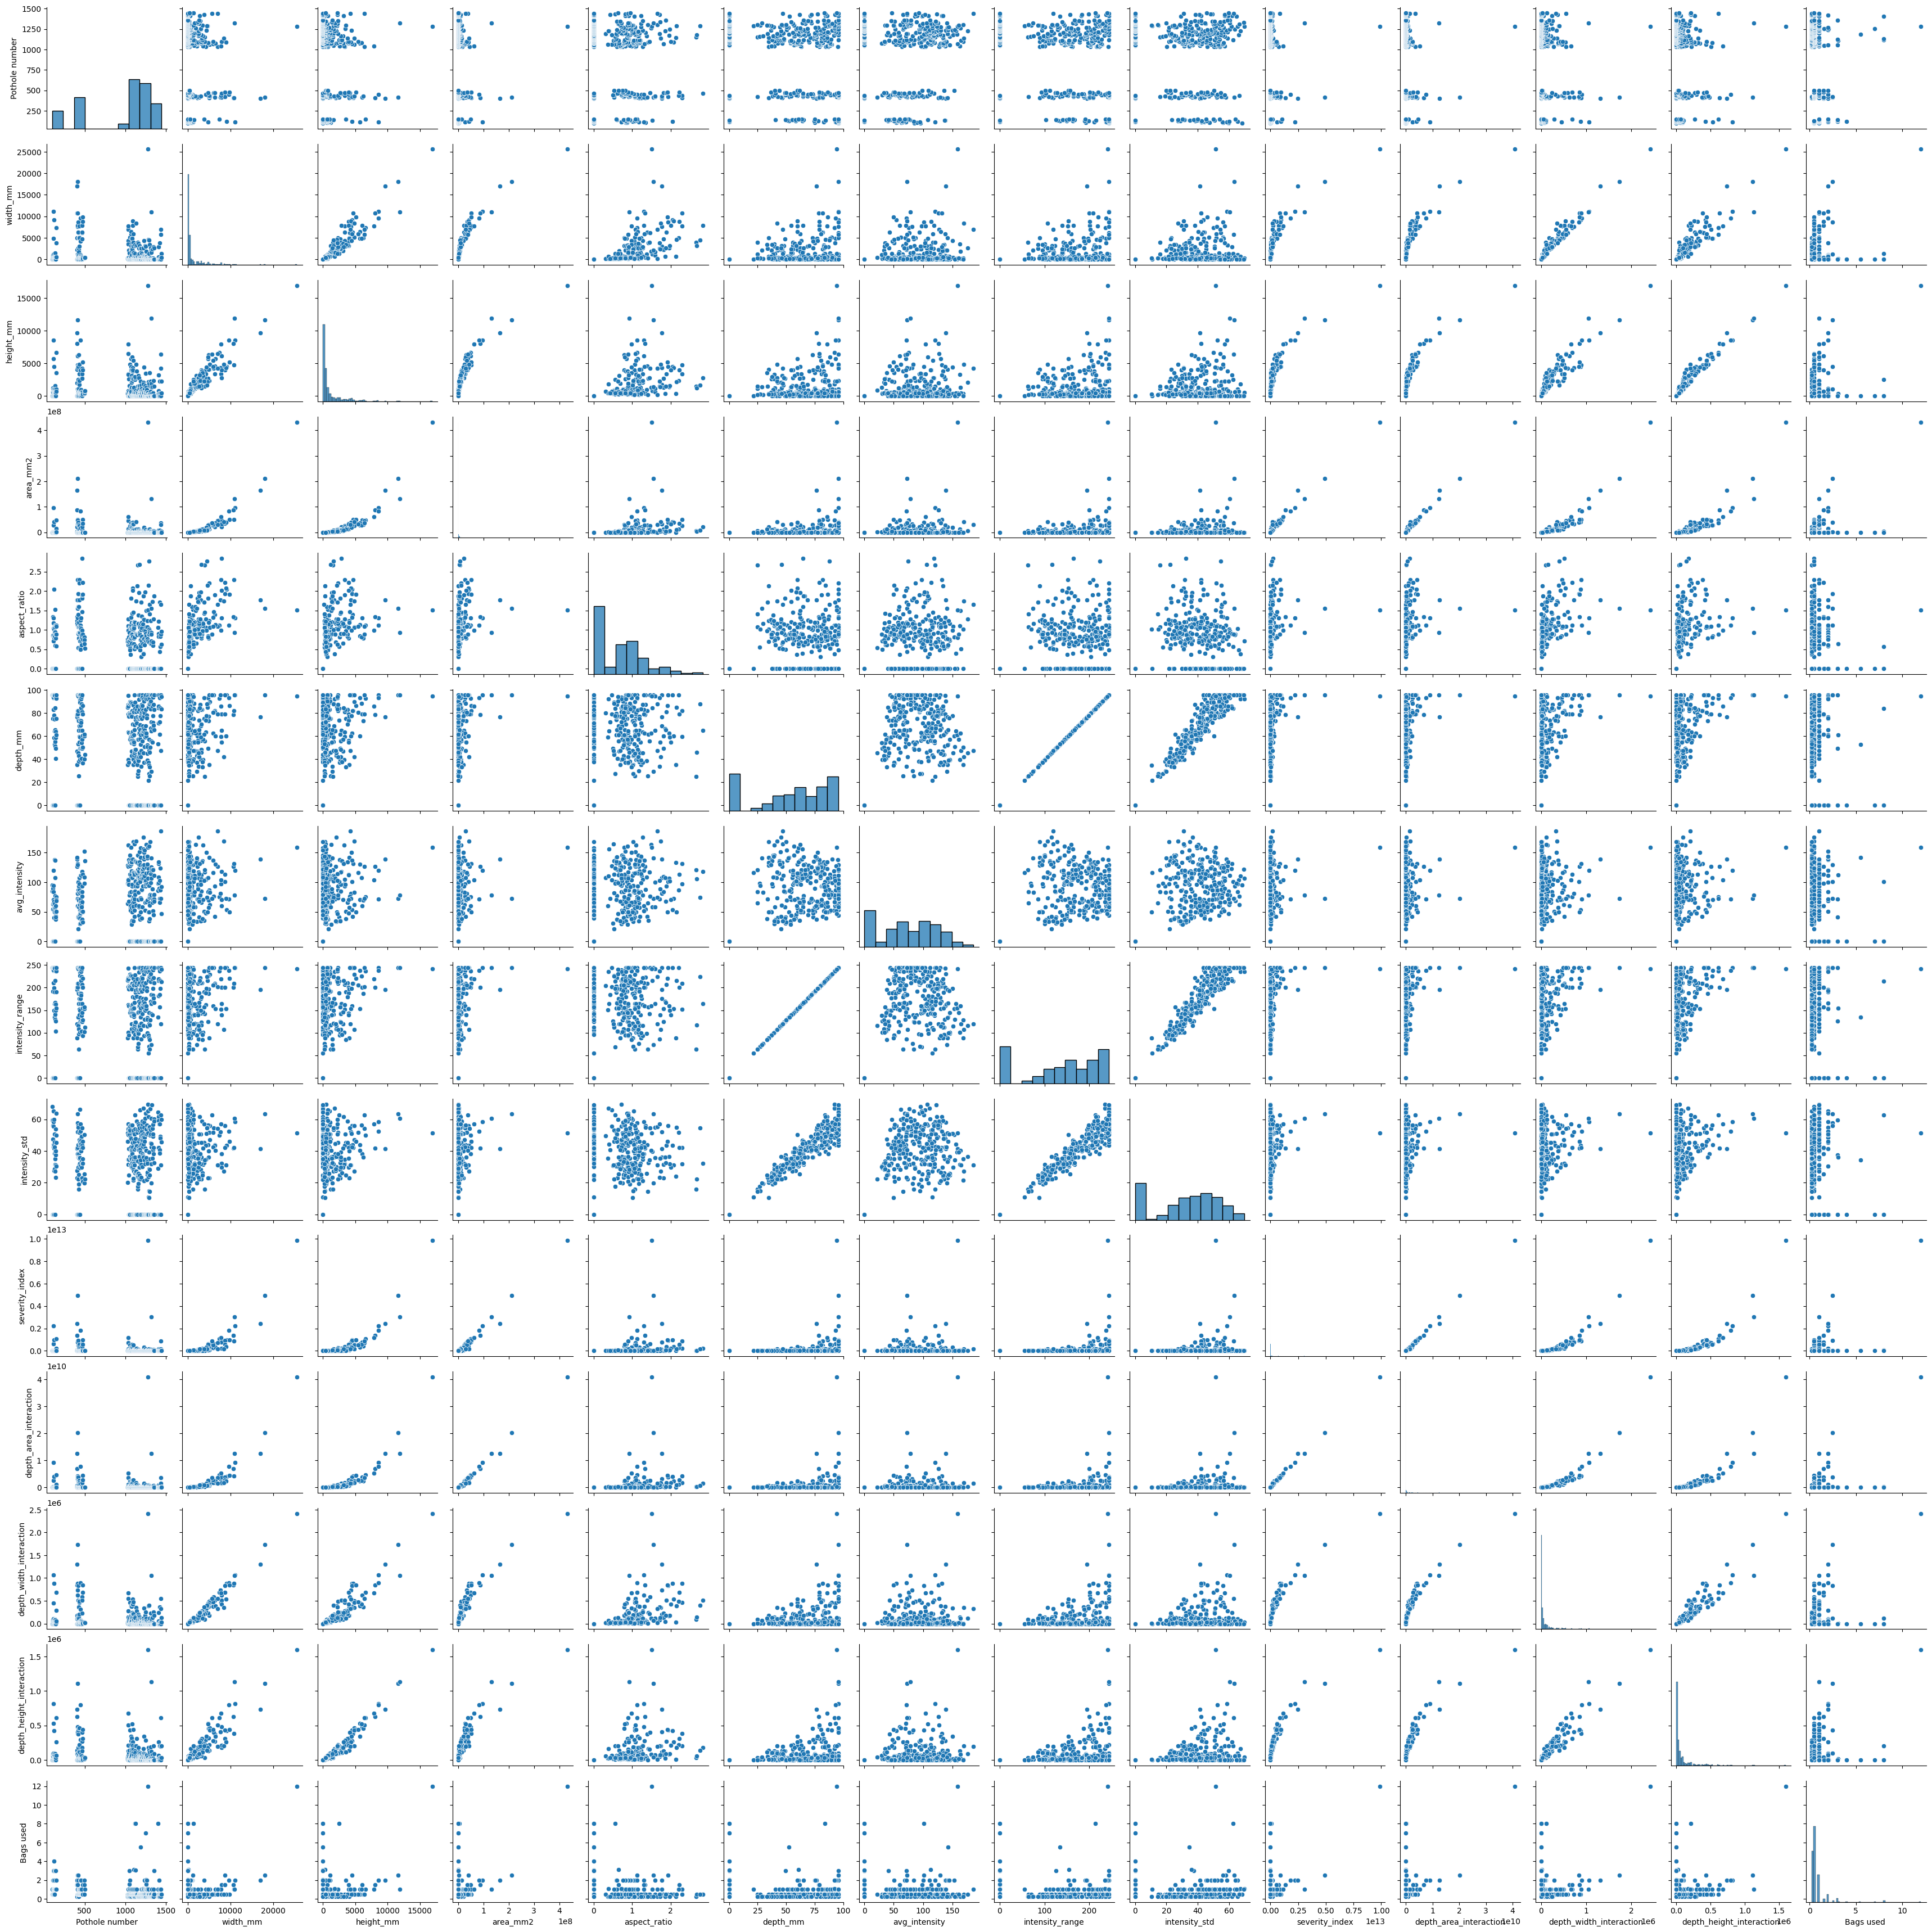

In [41]:
import seaborn as sns
sns.pairplot(df_full)

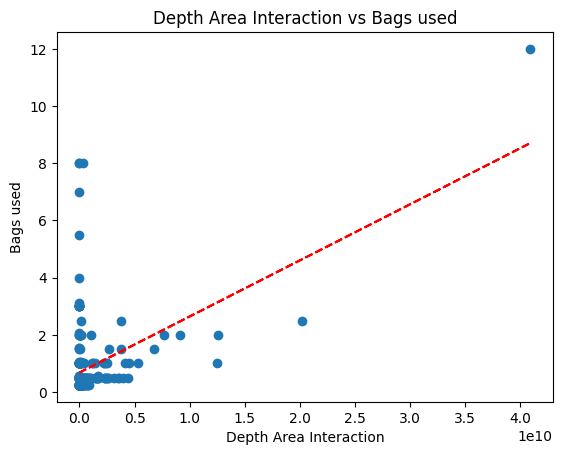

In [42]:
# df_full area depth interaction vs bags used
plt.scatter(df_full['depth_area_interaction'], df_full['Bags used '])
z = np.polyfit(df_full['depth_area_interaction'], df_full['Bags used '], 1)
p = np.poly1d(z)
plt.plot(df_full['depth_area_interaction'], p(
    df_full['depth_area_interaction']), "r--")
plt.xlabel('Depth Area Interaction')
plt.ylabel('Bags used')
plt.title('Depth Area Interaction vs Bags used')
plt.show()

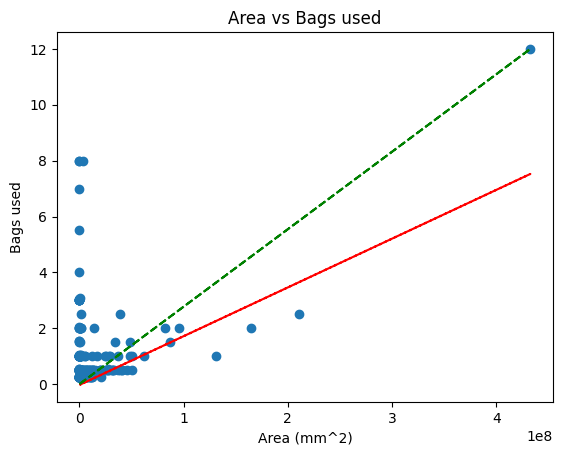

In [43]:
# df_full area vs bags used
plt.scatter(df_full['area_mm2'], df_full['Bags used '])
z = np.polyfit(df_full['area_mm2'], df_full['Bags used '], 1)
p = np.poly1d(z)
plt.plot(df_full['area_mm2'], p(df_full['area_mm2'])-0.7, "r--")
# plot line of bags used = 1e-8 * area_mm2
plt.plot(df_full['area_mm2'], 2.7731830562300084e-08 *
         df_full['area_mm2'], 'g--')
plt.xlabel('Area (mm^2)')
plt.ylabel('Bags used')
plt.title('Area vs Bags used')
plt.show()

In [44]:
df_full.loc[305]['Bags used ']/df_full.loc[305]['area_mm2']

2.7731830562300084e-08

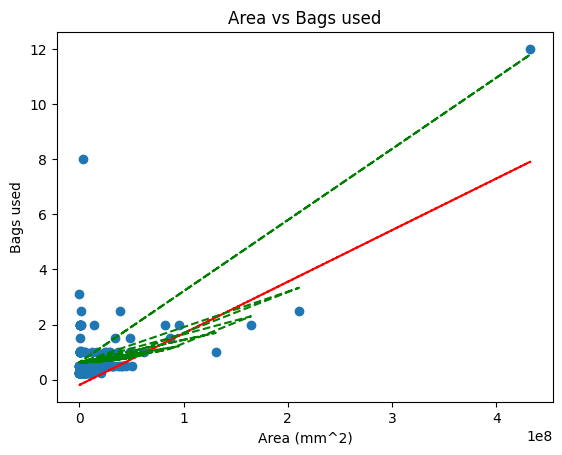

In [45]:
# plot area_mm2 vs bags used after dropping all rows with area_mm2 = 0
df_full_no_zeros = df_full[df_full['area_mm2'] != 0]
plt.scatter(df_full_no_zeros['area_mm2'], df_full_no_zeros['Bags used '])

z = np.polyfit(df_full_no_zeros['area_mm2'], df_full_no_zeros['Bags used '], 1)
p = np.poly1d(z)
plt.plot(df_full_no_zeros['area_mm2'], p(df_full_no_zeros['area_mm2'])-0.7, "r--")

qz = np.polyfit(df_full_no_zeros['area_mm2'], df_full_no_zeros['Bags used '], 2)
q = np.poly1d(qz)
plt.plot(df_full_no_zeros['area_mm2'], q(
    df_full_no_zeros['area_mm2']), "g--")

plt.xlabel('Area (mm^2)')
plt.ylabel('Bags used')
plt.title('Area vs Bags used')
plt.show()

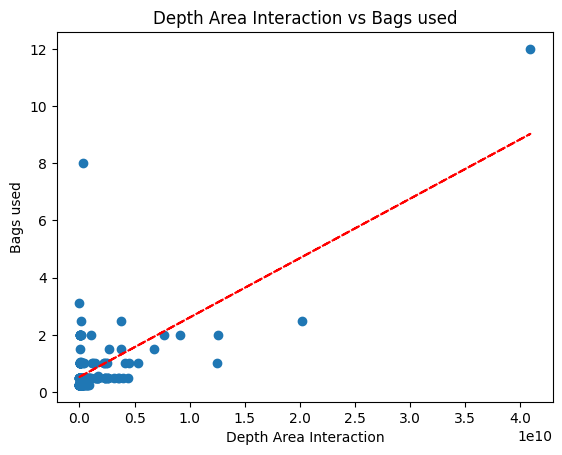

In [46]:
# plot depth area interaction vs bags used after dropping all rows with area_mm2 = 0
df_full_no_zeros = df_full[df_full['depth_area_interaction'] != 0]
plt.scatter(df_full_no_zeros['depth_area_interaction'],
            df_full_no_zeros['Bags used '])

z = np.polyfit(
    df_full_no_zeros['depth_area_interaction'], df_full_no_zeros['Bags used '], 1)
p = np.poly1d(z)
plt.plot(df_full_no_zeros['depth_area_interaction'], p(
    df_full_no_zeros['depth_area_interaction']), "r--")

plt.xlabel('Depth Area Interaction')
plt.ylabel('Bags used')
plt.title('Depth Area Interaction vs Bags used')
plt.show()

In [47]:
p

poly1d([2.07820817e-10, 5.30378932e-01])

## Some scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to be scaled (excluding 'image_filename' and 'bags_used')
columns_to_scale = df_full.columns.difference(['Pothole number', 'Bags used '])

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
df_full[columns_to_scale] = scaler.fit_transform(df_full[columns_to_scale])

In [49]:
df_full.head()

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction,Bags used
0,101,0.000000,0.000000,0.000000,0.000000,1.000000,0.513785,1.000000,0.977615,0.000000,0.000000,0.000000,0.000000,0.5
1,102,0.000000,0.000000,0.000000,0.000000,1.000000,0.457248,1.000000,0.857789,0.000000,0.000000,0.000000,0.000000,1.0
2,106,0.029945,0.033739,0.001010,0.473072,1.000000,0.292023,1.000000,0.803160,0.001036,0.001023,0.030318,0.034159,0.5
3,107,0.020680,0.037191,0.000769,0.296375,1.000000,0.339949,1.000000,0.856559,0.000788,0.000779,0.020937,0.037654,0.5
4,109,0.039344,0.068997,0.002715,0.303941,0.786885,0.481701,0.786885,0.680001,0.001723,0.002163,0.031345,0.054968,0.5


# Now for the test set

In [1]:
import pandas as pd

In [2]:
df_full = pd.concat([pd.read_csv('./good_data/data/train_s_processed.csv'), pd.read_csv('./good_data/data/val_processed.csv')])

In [3]:
df_full.shape

(824, 14)

In [5]:
df_full.head()

,Pothole number,width_mm,height_mm,area_mm2,aspect_ratio,depth_mm,avg_intensity,intensity_range,intensity_std,severity_index,depth_area_interaction,depth_width_interaction,depth_height_interaction,Bags used
0,38,0.122634,0.222506,0.032135,0.165185,0.569672,0.635066,0.569672,0.463394,0.012049,0.019677,0.075093,0.126756,1.0
1,39,0.224125,0.235989,0.062288,0.284644,0.598361,0.572464,0.598361,0.532147,0.025767,0.040062,0.144151,0.141207,0.5
2,40,0.220971,0.455185,0.118453,0.145496,0.995902,0.689132,0.995902,0.762175,0.135740,0.126802,0.236546,0.453319,0.5
3,41,0.189393,0.234354,0.052271,0.242211,0.561475,0.666551,0.561475,0.442836,0.019039,0.031547,0.114303,0.131584,1.0
4,42,0.213517,0.070550,0.017740,0.907062,0.336066,0.733342,0.336066,0.228843,0.002315,0.006408,0.077130,0.023710,1.0


In [6]:
df_full = df_full[['Pothole number', 'width_mm', 'height_mm', 'area_mm2', 'Bags used ']]

In [23]:
df_test = pd.read_csv('./good_data/data/test_processed.csv')

In [24]:
df_test = df_test[['Pothole number', 'width_mm',
                   'height_mm', 'area_mm2', 'Bags used ']]

In [9]:
df_test.head()

,Pothole number,width_mm,height_mm,area_mm2,Bags used
0,103,0.562042,0.397217,0.298381,NaN
1,104,0.572546,0.173004,0.174225,NaN
2,105,0.489001,0.458246,0.300131,NaN
3,108,0.270496,0.087696,0.067384,NaN
4,114,0.381871,0.256768,0.163278,NaN


In [10]:
df_full.head()

,Pothole number,width_mm,height_mm,area_mm2,Bags used
0,38,0.122634,0.222506,0.032135,1.0
1,39,0.224125,0.235989,0.062288,0.5
2,40,0.220971,0.455185,0.118453,0.5
3,41,0.189393,0.234354,0.052271,1.0
4,42,0.213517,0.070550,0.017740,1.0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Separate features and target
X_train = df_full.drop(columns=['Pothole number', 'Bags used '])
y_train = df_full['Bags used ']

# Fit a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = model.predict(X_train)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")

Training MSE: 0.7023
Training R²: 0.2389


In [12]:
X_test = df_test.drop(columns=['Pothole number', 'Bags used '])

In [13]:
model.predict(X_test).tolist()

[2.298946361112722,
 1.639200182520569,
 2.280301627833463,
 0.9611551384367278,
 1.510704373800906,
 1.014437723861426,
 1.0238929865476651,
 6.235149806020358,
 2.3986286906110337,
 1.7307190129486723,
 1.4515849038432413,
 0.7306448248495633,
 1.2690568976593706,
 1.1686056837102523,
 1.3423310226198508,
 1.8573731448989412,
 0.865990147518612,
 0.5091043857704618,
 1.510704373800906,
 1.1116190619874438,
 1.0606423826400002,
 1.0207289340898802,
 0.8999891937306739,
 0.9685935806151637,
 1.510704373800906,
 1.510704373800906,
 0.9794260718461937,
 0.7219023875753252,
 1.0840933634462888,
 1.2793881291846616]

In [14]:
df_test['Bags used '] = model.predict(X_test)

In [15]:
X_test

,width_mm,height_mm,area_mm2
0,0.562042,0.397217,0.298381
1,0.572546,0.173004,0.174225
2,0.489001,0.458246,0.300131
3,0.270496,0.087696,0.067384
4,0.381871,0.256768,0.163278
5,0.172056,0.209849,0.084577
6,0.138102,0.260543,0.088973
7,1.000000,1.000000,1.000000
8,0.743028,0.299598,0.304476
9,0.366692,0.366517,0.205805


In [16]:
df_test

,Pothole number,width_mm,height_mm,area_mm2,Bags used
0,103,0.562042,0.397217,0.298381,2.298946
1,104,0.572546,0.173004,0.174225,1.639200
2,105,0.489001,0.458246,0.300131,2.280302
3,108,0.270496,0.087696,0.067384,0.961155
4,114,0.381871,0.256768,0.163278,1.510704
5,143,0.172056,0.209849,0.084577,1.014438
6,144,0.138102,0.260543,0.088973,1.023893
7,406,1.000000,1.000000,1.000000,6.235150
8,434,0.743028,0.299598,0.304476,2.398629
9,450,0.366692,0.366517,0.205805,1.730719


In [17]:
df_preds = df_test[['Pothole number', 'Bags used ']]

In [18]:
df_preds

,Pothole number,Bags used
0,103,2.298946
1,104,1.639200
2,105,2.280302
3,108,0.961155
4,114,1.510704
5,143,1.014438
6,144,1.023893
7,406,6.235150
8,434,2.398629
9,450,1.730719


# Try with other models

## SVR

In [21]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the SVR model with RBF kernel
svr_model = SVR(kernel='rbf')

# Fit the model on the training data
svr_model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = svr_model.predict(X_train)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"SVR Training MSE: {train_mse:.4f}")
print(f"SVR Training R²: {train_r2:.4f}")

SVR Training MSE: 0.7112
SVR Training R²: 0.2292


In [25]:
# df_test = pd.read_csv('./good_data/data/test_processed.csv')
X_test = df_test.drop(columns=['Pothole number', 'Bags used '])
df_test['Bags used '] = svr_model.predict(X_test)
df_preds = df_test[['Pothole number', 'Bags used ']]
df_preds.to_csv('./Predictions/svr.csv', index=False)

## Random Forest

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Random Forest Training MSE: {train_mse:.4f}")
print(f"Random Forest Training R²: {train_r2:.4f}")

Random Forest Training MSE: 0.3486
Random Forest Training R²: 0.6222


In [27]:
# df_test = pd.read_csv('./good_data/data/test_processed.csv')
X_test = df_test.drop(columns=['Pothole number', 'Bags used '])
df_test['Bags used '] = rf_model.predict(X_test)
df_preds = df_test[['Pothole number', 'Bags used ']]
df_preds.to_csv('./Predictions/rf.csv', index=False)

## Gradient Boosting Regressor

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting model
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
gbr_model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = gbr_model.predict(X_train)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Gradient Boosting Training MSE: {train_mse:.4f}")
print(f"Gradient Boosting Training R²: {train_r2:.4f}")

Gradient Boosting Training MSE: 0.3846
Gradient Boosting Training R²: 0.5832


In [29]:
# df_test = pd.read_csv('./good_data/data/test_processed.csv')
X_test = df_test.drop(columns=['Pothole number', 'Bags used '])
df_test['Bags used '] = gbr_model.predict(X_test)
df_preds = df_test[['Pothole number', 'Bags used ']]
df_preds.to_csv('./Predictions/gbr.csv', index=False)

## Neural Network Using PyTorch

In [30]:
# Train-validation split from X_train and y_train
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# Create a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.fc7(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(1000):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        print(f"Validation Loss: {val_loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Neural Network Training MSE: {train_mse:.4f}")
print(f"Neural Network Training R²: {train_r2:.4f}")

Epoch 1, Loss: 1.2078
Validation Loss: 0.5666
Epoch 2, Loss: 0.8608
Validation Loss: 0.4991
Epoch 3, Loss: 0.8756
Validation Loss: 0.4408
Epoch 4, Loss: 0.7942
Validation Loss: 0.5336
Epoch 5, Loss: 0.7763
Validation Loss: 0.5304
Epoch 6, Loss: 0.7762
Validation Loss: 0.5640
Epoch 7, Loss: 0.7817
Validation Loss: 0.4880
Epoch 8, Loss: 0.7890
Validation Loss: 0.4564
Epoch 9, Loss: 0.7931
Validation Loss: 0.4644
Epoch 10, Loss: 0.7837
Validation Loss: 0.4709
Epoch 11, Loss: 0.8135
Validation Loss: 1.0540
Epoch 12, Loss: 0.9523
Validation Loss: 0.7535
Epoch 13, Loss: 0.8911
Validation Loss: 0.5571
Epoch 14, Loss: 0.8104
Validation Loss: 0.7113
Epoch 15, Loss: 0.7637
Validation Loss: 0.4556
Epoch 16, Loss: 0.7638
Validation Loss: 0.4356
Epoch 17, Loss: 0.7640
Validation Loss: 0.6345
Epoch 18, Loss: 0.7860
Validation Loss: 0.5812
Epoch 19, Loss: 0.7678
Validation Loss: 0.5864
Epoch 20, Loss: 0.7813
Validation Loss: 0.5195
Epoch 21, Loss: 0.7796
Validation Loss: 0.6362
Epoch 22, Loss: 0.7882

In [ ]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).numpy()

In [ ]:
df_test = pd.read_csv('./good_data/data/test_processed.csv')
X_test = df_test.drop(columns=['Pothole number', 'Bags used '])
df_test['Bags used '] = y_test_pred
df_preds = df_test[['Pothole number', 'Bags used ']]
df_preds.to_csv('./Predictions/fccnn.csv', index=False)